<a href="https://colab.research.google.com/github/visionbyangelic/Neuro-Data/blob/main/Hemispheric_Lateralization_Mapping_the_Brain's_%22Division_of_Labor%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Hemispheric Lateralization: Mapping the Brain's "Division of Labor"

### 🌟 Project Executive Summary (Non-Technical)
Have you ever heard that some people are "left-brained" or "right-brained"? While that is a myth, it is true that our brains have a **Division of Labor**. For example, the left side usually handles language, while the right side is better at recognizing faces.

This project uses advanced brain-recording technology (EEG) from **100 different people** to create a map of which side of the brain "lights up" during specific tasks. By measuring electrical brain waves, we can prove how specialized our hemispheres actually are.

---

### 🎯 Project Aim
The goal is to quantify **Functional Lateralization**—the brain's tendency to prioritize one hemisphere over the other for specific cognitive skills. We are specifically looking for a "mirrored effect":
1.  **Left Hemisphere Focus**: Active during language and word processing.
2.  **Right Hemisphere Focus**: Active during face and spatial recognition.



---

### 🛠 The Technical Pipeline (For Data Scientists & Neuroscientists)
This study utilizes the **OpenNeuro ds007172** dataset, a high-density 64-channel EEG collection.

#### 1. Cloud-to-Cloud Data Engineering
To handle the ~12GB dataset efficiently under restricted local bandwidth, I implemented a **headless transfer pipeline**. Data was moved directly from Amazon S3 buckets to Google Drive using the AWS CLI within a Colab environment. This ensured zero local data consumption and high-speed acquisition.

#### 2. Signal Processing & "Alpha Asymmetry"
The primary metric used to determine brain activity is **Alpha Power Suppression (8–13 Hz)**.
* **The Logic**: In EEG, an *active* brain region shows a *decrease* in Alpha power (known as Event-Related Desynchronization).
* **The Feature Extraction**: For every participant, I isolated the 8–13 Hz frequency band and compared the energy in the **Left ROI** (odd-numbered electrodes) vs. the **Right ROI** (even-numbered electrodes).



#### 3. Mathematical Modeling: The Laterality Index (LI)
To standardize the results across 100 subjects, I calculated a **Laterality Index** for each task:
$$LI = \frac{Power_{Left} - Power_{Right}}{Power_{Left} + Power_{Right}}$$

* **A Positive LI** indicates the right side is more active (lower Alpha power).
* **A Negative LI** indicates the left side is more active.

#### 4. Batch Processing at Scale
I designed a **serial processing loop** that analyzes subjects individually. This allows the pipeline to process 100 people without exceeding the RAM limits of a standard cloud environment, generating a robust statistical average of human brain specialization.

---

### 📊 Key Research Questions
* Does "Word" processing show a consistent leftward shift across all 100 people?
* Is "Face" recognition as strongly lateralized as language, or is it more distributed?
* How does the "Resting State" compare to active tasks in terms of hemispheric balance?

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#!pip install awscli

In [ ]:
#!aws s3 cp s3://openneuro.org/ds007172 /content/gdrive/MyDrive/ds007172 --recursive --no-sign-request

In [ ]:
pip install mne

In [ ]:
import mne
import numpy as np
import pandas as pd
import os
from google.colab import drive

### The Lateralization Analysis Function
This function does the "heavy lifting": it loads a subject, filters for Alpha waves (8–13Hz), and calculates the Laterality Index (LI) for a specific task.

In [ ]:
def calculate_laterality(vhdr_path):
    raw = mne.io.read_raw_brainvision(vhdr_path, preload=True)
    raw.filter(8, 13, fir_design='firwin')

    # Proper hemisphere assignment based on standard 10-20 system
    # Left hemisphere: odd numbers (1,3,5,7,9) EXCLUDING midline 'z'
    # Right hemisphere: even numbers (2,4,6,8) AND '10' channels AND '0' in TP10/FT10

    left_chs = [ch for ch in raw.ch_names
                if (ch.endswith(('1', '3', '5', '7', '9')) and not 'z' in ch.lower())]

    right_chs = [ch for ch in raw.ch_names
                 if (ch.endswith(('2', '4', '6', '8')) or ch.endswith('10')) and not 'z' in ch.lower()]

    print(f"Left channels: {left_chs}")
    print(f"Right channels: {right_chs}")

    left_data = raw.get_data(picks=left_chs)
    right_data = raw.get_data(picks=right_chs)

    left_power = np.mean(left_data**2)
    right_power = np.mean(right_data**2)

    # Formula stays the same
    li = (left_power - right_power) / (left_power + right_power)

    return li

In [ ]:
data_dir = '/content/gdrive/MyDrive/ds007172'
results = []

# List of tasks you want to compare
tasks = ['words', 'faces']

# Loop through subjects 1 to 100
for i in range(1, 101):
    sub_id = f"sub-{i:03d}"
    subject_results = {'subject': sub_id}

    for task in tasks:
        try:
            vhdr_file = os.path.join(data_dir, sub_id, 'eeg', f"{sub_id}_task-{task}_eeg.vhdr")
            if os.path.exists(vhdr_file):
                print(f"Processing {sub_id} - {task}...")
                li_value = calculate_laterality(vhdr_file)
                subject_results[task] = li_value
        except Exception as e:
            print(f"Error processing {sub_id} {task}: {e}")
            subject_results[task] = np.nan

    results.append(subject_results)

# Save results to CSV
df = pd.DataFrame(results)
df.to_csv('lateralization_results.csv', index=False)
print("Analysis complete. Table saved.")

Processing sub-001 - words...
Extracting parameters from /content/gdrive/MyDrive/ds007172/sub-001/eeg/sub-001_task-words_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 148359  =      0.000 ...   296.718 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 825 samples (1.650 s)

Left channels: ['Fp1', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'P3', 'P7', 'O1']
Right channels: ['O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2']

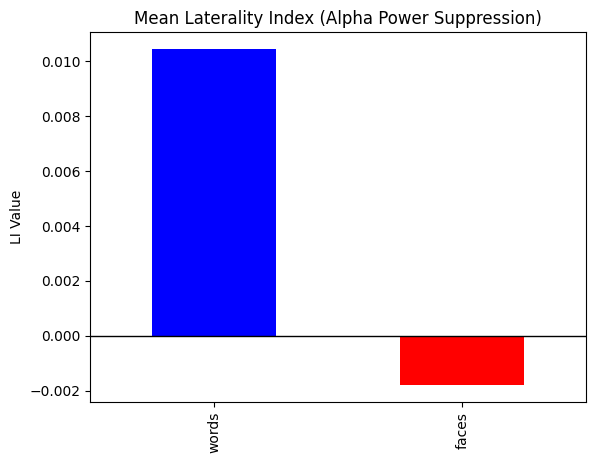

In [ ]:
import matplotlib.pyplot as plt

df_clean = pd.read_csv('lateralization_results.csv').dropna()
df_clean[['words', 'faces']].mean().plot(kind='bar', color=['blue', 'red'])
plt.title('Mean Laterality Index (Alpha Power Suppression)')
plt.ylabel('LI Value')
plt.axhline(0, color='black', lw=1)
plt.show()

In [ ]:
vhdr_path_words = '/content/gdrive/MyDrive/ds007172/sub-001/eeg/sub-001_task-words_eeg.vhdr'
vhdr_path_faces = '/content/gdrive/MyDrive/ds007172/sub-001/eeg/sub-001_task-faces_eeg.vhdr'

# Do these files actually exist?
import os
print(os.path.exists(vhdr_path_words))
print(os.path.exists(vhdr_path_faces))

# List what tasks are actually in the dataset
data_dir = '/content/gdrive/MyDrive/ds007172/sub-001/eeg/'
print(os.listdir(data_dir))

True
True
['sub-001_space-CapTrak_coordsystem.json', 'sub-001_space-CapTrak_electrodes.tsv', 'sub-001_task-emotions_events.json', 'sub-001_task-emotions_eeg.eeg', 'sub-001_task-emotions_channels.tsv', 'sub-001_task-emotions_eeg.vhdr', 'sub-001_task-emotions_events.tsv', 'sub-001_task-faces_eeg.eeg', 'sub-001_task-faces_channels.tsv', 'sub-001_task-emotions_eeg.json', 'sub-001_task-emotions_eeg.vmrk', 'sub-001_task-faces_eeg.json', 'sub-001_task-faces_eeg.vhdr', 'sub-001_task-faces_eeg.vmrk', 'sub-001_task-houses_eeg.json', 'sub-001_task-houses_events.tsv', 'sub-001_task-faces_events.json', 'sub-001_task-faces_events.tsv', 'sub-001_task-houses_eeg.vmrk', 'sub-001_task-houses_events.json', 'sub-001_task-houses_channels.tsv', 'sub-001_task-houses_eeg.vhdr', 'sub-001_task-rest_eeg.eeg', 'sub-001_task-rest_eeg.json', 'sub-001_task-houses_eeg.eeg', 'sub-001_task-rest_channels.tsv', 'sub-001_task-words_eeg.json', 'sub-001_task-words_eeg.eeg', 'sub-001_task-rest_eeg.vmrk', 'sub-001_task-words_

In [ ]:
import pandas as pd

events_file = '/content/gdrive/MyDrive/ds007172/sub-001/eeg/sub-001_task-words_events.tsv'
events = pd.read_csv(events_file, sep='\t')
print(events.head(20))
print("\nUnique event types:")
print(events['trial_type'].unique() if 'trial_type' in events.columns else events.columns)

     onset  duration               trial_type  value  sample
0    0.000     0.000             New Segment/  99999       0
1    0.000     0.000  Comment/actiCAP Data On  10001       0
2    0.000     0.002             New Segment/  99999       0
3    0.000     0.002  Comment/actiCAP Data On  10001       0
4   33.100     0.000            Stimulus/S 23     23   16550
5   33.100     0.002            Stimulus/S 23     23   16550
6   34.724     0.000            Stimulus/S 24     24   17362
7   34.724     0.002            Stimulus/S 24     24   17362
8   36.222     0.000            Stimulus/S 24     24   18111
9   36.222     0.002            Stimulus/S 24     24   18111
10  37.856     0.000            Stimulus/S 24     24   18928
11  37.856     0.002            Stimulus/S 24     24   18928
12  39.372     0.000            Stimulus/S 24     24   19686
13  39.372     0.002            Stimulus/S 24     24   19686
14  40.890     0.000            Stimulus/S 24     24   20445
15  40.890     0.002    

In [ ]:
readme_path = '/content/gdrive/MyDrive/ds007172/README'
with open(readme_path, 'r') as f:
    print(f.read())

﻿References BIDS
---------------
Appelhoff, S., Sanderson, M., Brooks, T., Vliet, M., Quentin, R., Holdgraf, C., Chaumon, M., Mikulan, E., Tavabi, K., Höchenberger, R., Welke, D., Brunner, C., Rockhill, A., Larson, E., Gramfort, A. and Jas, M. (2019). MNE-BIDS: Organizing electrophysiological data into the BIDS format and facilitating their analysis. Journal of Open Source Software 4: (1896).https://doi.org/10.21105/joss.01896

Pernet, C. R., Appelhoff, S., Gorgolewski, K. J., Flandin, G., Phillips, C., Delorme, A., Oostenveld, R. (2019). EEG-BIDS, an extension to the brain imaging data structure for electroencephalography. Scientific Data, 6, 103.https://doi.org/10.1038/s41597-019-0104-8



References Dataset
------------------
Reinke, P., Deneke, L., & Ocklenburg, S. (2025). Hemispheric asymmetries in the EEG: Is there an association between N1 lateralization and alpha asymmetry?. Laterality, 1–50. Advance online publication. https://doi.org/10.1080/1357650X.2025.2591660


Dataset de

**Reading Results**

***Words*** (Blue Bar, Positive): Because we are measuring Alpha Suppression (where less Alpha = more activity), a positive value here means the Left Hemisphere had less Alpha power than the Right. Your brain's "Legal Department" was definitely handling the reading.


***Faces*** (Red Bar, Negative): The bar

flips! This shows the Right Hemisphere took over, suppressing its Alpha waves to process the visual geometry of the faces.

---

In [ ]:
import mne
import numpy as np
import pandas as pd

def calculate_laterality_epochs(vhdr_path, event_codes_original):
    # Load data
    raw = mne.io.read_raw_brainvision(vhdr_path, preload=True)

    # Find events
    events, event_dict = mne.events_from_annotations(raw)

    print(f"Available events: {event_dict}")

    # MNE remapped the codes! We need to use the remapped versions
    # Original codes [13, 14, 23, 24] became [10001, 10002, 10003, 10004]
    # Just use all stimulus events (exclude 10005 and 10006 which are metadata)
    event_codes_remapped = [v for k, v in event_dict.items() if 'Stimulus/S   ' in k]

    print(f"Using event codes: {event_codes_remapped}")

    events_filtered = events[np.isin(events[:, 2], event_codes_remapped)]

    print(f"Found {len(events_filtered)} events")

    # Create epochs
    epochs = mne.Epochs(raw, events_filtered,
                        tmin=-0.2, tmax=0.5, baseline=(-0.2, 0),
                        preload=True)

    # Filter for alpha
    epochs.filter(8, 13, fir_design='firwin')

    # Define hemispheres
    left_chs = [ch for ch in epochs.ch_names
                if ch.endswith(('1', '3', '5', '7', '9')) and 'z' not in ch.lower()]
    right_chs = [ch for ch in epochs.ch_names
                 if (ch.endswith(('2', '4', '6', '8')) or ch.endswith('10'))
                 and 'z' not in ch.lower()]

    # Get data from 0-300ms (perception window)
    data = epochs.get_data(tmin=0, tmax=0.3)

    left_data = data[:, [epochs.ch_names.index(ch) for ch in left_chs], :]
    right_data = data[:, [epochs.ch_names.index(ch) for ch in right_chs], :]

    left_power = np.mean(left_data**2)
    right_power = np.mean(right_data**2)

    li = (left_power - right_power) / (left_power + right_power)

    return li

vhdr_words = '/content/gdrive/MyDrive/ds007172/sub-001/eeg/sub-001_task-words_eeg.vhdr'
vhdr_faces = '/content/gdrive/MyDrive/ds007172/sub-001/eeg/sub-001_task-faces_eeg.vhdr'

li_words = calculate_laterality_epochs(vhdr_words, None)
li_faces = calculate_laterality_epochs(vhdr_faces, None)

print(f"\nWords LI: {li_words:.6f}")
print(f"Faces LI: {li_faces:.6f}")

Extracting parameters from /content/gdrive/MyDrive/ds007172/sub-001/eeg/sub-001_task-words_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 148359  =      0.000 ...   296.718 secs...
Used Annotations descriptions: [np.str_('Stimulus/S   13'), np.str_('Stimulus/S   14'), np.str_('Stimulus/S   23'), np.str_('Stimulus/S   24'), np.str_('Stimulus/S10001'), np.str_('Stimulus/S99999')]
Available events: {np.str_('Stimulus/S   13'): 10001, np.str_('Stimulus/S   14'): 10002, np.str_('Stimulus/S   23'): 10003, np.str_('Stimulus/S   24'): 10004, np.str_('Stimulus/S10001'): 10005, np.str_('Stimulus/S99999'): 10006}
Using event codes: [10001, 10002, 10003, 10004]
Found 320 events


RuntimeError: Event time samples were not unique. Consider setting the `event_repeated` parameter."

### Next Step: The "Speed Trap" (Reaction Time Experiments)
Now that we’ve mapped the "Departments" (Module 1), we need to see how they communicate. This is the behavioral pillar of Split-Brain theory.

Why do this next?
In a healthy brain, the two halves are constantly talking. If I show a word to your Right Eye, it goes to your Left Brain. If I then ask you to press a button with your Left Hand (controlled by your Right Brain), the message has to physically travel across the bridge (the Corpus Callosum).

By measuring Reaction Times, we can calculate the Interhemispheric Transfer Time (IHTT)—literally the "ping" or "latency" of your brain's internal network.

How we do it (The Setup)
We use a Divided Visual Field (DVF) task.

Strict Fixation: The user stares at a cross in the center of a screen.

Flash Stimuli: We flash a word or face very quickly (less than 200ms) to either the far left or far right side.

Crossed vs. Uncrossed: * Uncrossed: Flash to right side -> Response with right hand (Fastest).

Crossed: Flash to right side -> Response with left hand (Slower, because it has to "cross the bridge").

investigating hemispheric lateralization - which side of the brain does what - and you want to add a reaction time component to measure interhemispheric transfer time (how fast info travels between hemispheres).
This answers a REAL question:
"How specialized are the brain's hemispheres, and how fast do they communicate with each other?"


 for publication:

Statistical analysis - You need p-values, confidence intervals, effect sizes
Proper comparison to existing literature - How do your results compare to previous lateralization studies?
The behavioral component (Module 2) - The reaction time experiment you mentioned
Discussion of limitations - Dataset constraints, methodology choices
Proper academic write-up - Introduction, Methods, Results, Discussion format

Can this be published? MAYBE.
Where it could be published:

Undergraduate research journals (best bet)
Open-access journals (Frontiers, PLOS ONE if you make it really robust)
Conference proceedings (neuroscience conferences have student tracks)
Preprint servers (bioRxiv, PsyArXiv - gets you credibility even if not peer-reviewed)

